=== Stage 1: point prediction (log-price) ===
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2996]	valid_0's l2: 0.017229
fold 0: RMSE = 97860.001
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2999]	valid_0's l2: 0.0176686
fold 1: RMSE = 98992.324
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[3000]	valid_0's l2: 0.017804
fold 2: RMSE = 101010.252
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2986]	valid_0's l2: 0.0179148
fold 3: RMSE = 100998.268
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2996]	valid_0's l2: 0.0178073
fold 4: RMSE = 99463.233

Full OOF RMSE: 99672.178

=== Stage 2: quantile α = 0.05 ===
Training until validation scores don't improve for 200 rounds


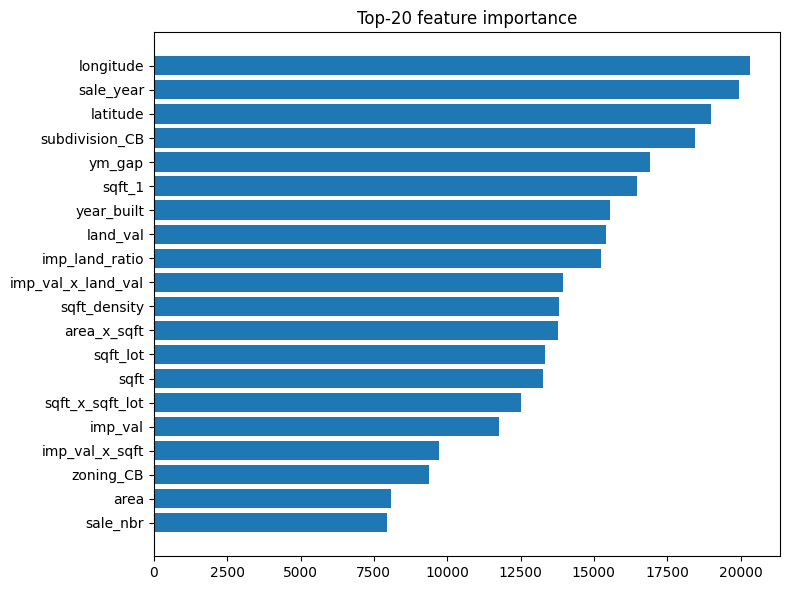

In [1]:
# ============================================================
#  Prediction-Interval Competition II 
#  (LightGBM + quantile models)
# ============================================================

import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")          # Silence all warnings

# ============================================================
# 2. Reproducibility
# ============================================================
def seed_everything(seed: int = 2025) -> None:
    """Seed Python, NumPy and random for full reproducibility."""
    random.seed(seed)
    np.random.seed(seed)

seed_everything()


# ============================================================
# 3. Data loading & basic cleanup
# ============================================================
DATA_DIR = "/kaggle/input/prediction-interval-competition-ii-house-price"                              # Root folder with CSVs
DROP_COLS = [                              # Useless / leakage columns
    "id", "golf", "view_rainier", "view_skyline", "view_lakesamm",
    "view_otherwater", "view_other"
]

# Train / test splits provided by competition host
train = (
    pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))
      .drop(DROP_COLS, axis=1)
)
test = (
    pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
      .drop(DROP_COLS, axis=1)
)

y_true = train["sale_price"].values        # Ground-truth target


# ============================================================
# 4. Feature engineering (hand-crafted domain logic)
# ============================================================
NUMS = [                                   # Main numeric fields
    "area", "land_val", "imp_val", "sqft_lot", "sqft", "sqft_1",
    "sqft_fbsmt", "garb_sqft", "gara_sqft"
]

def FE(df: pd.DataFrame) -> pd.DataFrame:
    """Generate interaction, temporal, ratio and log-scaled features."""
    df = df.copy()

    # 4.1 Important pairwise interactions
    for a, b in [
        ("imp_val", "land_val"),
        ("sqft", "sqft_lot"),
        ("imp_val", "sqft"),
        ("area", "sqft")
    ]:
        df[f"{a}_x_{b}"] = df[a] * df[b]

    # 4.2 Sale date decomposition
    df["sale_date"]  = pd.to_datetime(df["sale_date"])
    df["sale_year"]  = df["sale_date"].dt.year
    df["sale_month"] = df["sale_date"].dt.month
    df["ym_gap"]     = df["sale_year"] - df["year_built"]

    # 4.3 Cyclic (seasonal) encoding for month of sale
    df["month_sin"] = np.sin(2 * np.pi * df["sale_month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["sale_month"] / 12)

    # 4.4 Ratio-based features
    df["imp_land_ratio"] = df["imp_val"] / (df["land_val"] + 1)
    df["sqft_density"]   = df["sqft"]    / (df["sqft_lot"] + 1)
    df["basement_share"] = df["sqft_fbsmt"] / (df["sqft"] + 1)

    # 4.5 Log-transform heavy-tailed variables
    for col in ["land_val", "imp_val", "sqft", "sqft_lot"]:
        df[f"log_{col}"] = np.log1p(df[col])

    return df

train = FE(train)
test  = FE(test)


# ============================================================
# 5. Cross-validation split
# ============================================================
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=2025)

train["fold"] = -1
for fold, (_, val_idx) in enumerate(kf.split(train)):
    train.loc[val_idx, "fold"] = fold


# ============================================================
# 6. Column taxonomy
# ============================================================
cat_cols  = ["subdivision", "submarket", "zoning",
             "sale_warning", "join_status", "city"]

text_cols = [c for c in train.select_dtypes("object").columns
             if c not in cat_cols + ["sale_date"]]

drop_cols = ["sale_price", "fold", "sale_date"] + cat_cols + text_cols


# ============================================================
# 7. Helper utilities
# ============================================================
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Root-MSE wrapper (works with any sklearn version)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))


def make_matrices(_tr: pd.DataFrame,
                  _vl: pd.DataFrame,
                  _te: pd.DataFrame,
                  target_series: pd.Series):
    """
    Build numerical matrices with:
      • CatBoost target encoding for categorical cols  
      • Character-level TF-IDF for each free-text column  
    The same encoders are fitted only on train, then applied to
    validation and test to ensure no leakage.
    """
    tr, vl, te = _tr.copy(), _vl.copy(), _te.copy()

    # 7.1 CatBoost target encoding (mean-encoding w/ Bayesian smoothing)
    enc = CatBoostEncoder(cols=cat_cols,
                          random_state=2025,
                          sigma=5, a=10)
    enc.fit(tr[cat_cols], target_series.loc[tr.index])

    for df in (tr, vl, te):
        df_enc = enc.transform(df[cat_cols]).add_suffix("_CB")
        df.drop(columns=cat_cols, inplace=True)
        df[df_enc.columns] = df_enc

    # 7.2 Char-level TF-IDF → dense array per text field
    for col in text_cols:
        tfidf = TfidfVectorizer(analyzer="char",
                                ngram_range=(3, 4),
                                max_features=25,
                                min_df=5)
        tfidf.fit(train[col].fillna("").astype(str))

        for df in (tr, vl, te):
            mat   = tfidf.transform(df[col].fillna("").astype(str)).toarray()
            names = [f"{col}_tfidf_{i}" for i in range(mat.shape[1])]
            df.drop(columns=[col], inplace=True)
            df[names] = mat

    # 7.3 Final numeric matrices (consistent column sets)
    X_tr = tr.drop(columns=[c for c in drop_cols if c in tr.columns])
    X_vl = vl.drop(columns=[c for c in drop_cols if c in vl.columns])
    X_te = te.drop(columns=[c for c in drop_cols if c in te.columns])
    return X_tr, X_vl, X_te


# ============================================================
# 8. Base LightGBM hyper-parameters
# ============================================================
base_params = dict(
    boosting_type="gbdt",
    num_leaves=128,
    learning_rate=0.03,
    n_estimators=3_000,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.75,
    reg_alpha=0.5,
    reg_lambda=10,
    min_child_samples=50,
    random_state=2025,
    verbose=-1
)


# ============================================================
# 9. Stage 1 – Point prediction (log-price regression)
# ============================================================
oof_mean  = np.zeros(len(train))           # Out-of-fold predictions
pred_mean = np.zeros(len(test))            # Test-set mean forecast

print("=== Stage 1: point prediction (log-price) ===")
for fold in range(NFOLDS):
    tr_idx = train[train.fold != fold].index
    vl_idx = train[train.fold == fold].index

    # Build matrices with encoders fitted only on current train folds
    X_tr, X_vl, X_te = make_matrices(train.loc[tr_idx],
                                     train.loc[vl_idx],
                                     test,
                                     train["sale_price"])

    # Log-price stabilises variance
    y_tr = np.log1p(train.loc[tr_idx, "sale_price"])
    y_vl = np.log1p(train.loc[vl_idx, "sale_price"])

    model = LGBMRegressor(**base_params, objective="regression")
    model.fit(X_tr, y_tr,
              eval_set=[(X_vl, y_vl)],
              callbacks=[
                  lgb.early_stopping(stopping_rounds=200),
                  lgb.log_evaluation(period=0)
              ])

    oof_mean[vl_idx] = np.expm1(model.predict(X_vl))   # back-transform
    pred_mean       += np.expm1(model.predict(X_te)) / NFOLDS

    print(f"fold {fold}: RMSE = {rmse(train.loc[vl_idx, 'sale_price'], oof_mean[vl_idx]):.3f}")

print("\nFull OOF RMSE:", f"{rmse(y_true, oof_mean):.3f}")

train["pred_mean"] = oof_mean
test["pred_mean"]  = pred_mean


# ============================================================
# 10. Stage 2 – Prediction intervals via quantile regression
# ============================================================
def train_quantile(alpha: float):
    """Fit one LightGBM quantile model (α) across CV folds."""
    oof  = np.zeros(len(train))
    pred = np.zeros(len(test))

    print(f"\n=== Stage 2: quantile α = {alpha} ===")
    for fold in range(NFOLDS):
        tr_idx = train[train.fold != fold].index
        vl_idx = train[train.fold == fold].index

        X_tr, X_vl, X_te = make_matrices(train.loc[tr_idx],
                                         train.loc[vl_idx],
                                         test,
                                         train["sale_price"])

        y_tr = train.loc[tr_idx, "sale_price"]
        y_vl = train.loc[vl_idx, "sale_price"]

        q_params = base_params.copy()
        q_params.update(objective="quantile", alpha=alpha)

        mdl = LGBMRegressor(**q_params)
        mdl.fit(X_tr, y_tr,
                eval_set=[(X_vl, y_vl)],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=200),
                    lgb.log_evaluation(period=0)
                ])

        oof[vl_idx] += mdl.predict(X_vl)
        pred        += mdl.predict(X_te) / NFOLDS
    return oof, pred


# Lower (5 %) and upper (95 %) quantiles
oof_low,  pred_low  = train_quantile(0.05)
oof_high, pred_high = train_quantile(0.95)

train["q_low"]   = oof_low
train["q_high"]  = oof_high
test["q_low"]    = pred_low
test["q_high"]   = pred_high


# ============================================================
# 11. Interval calibration (scale tuning via Winkler score)
# ============================================================
def winkler(y, lower, upper, alpha: float = 0.1) -> float:
    """
    Winkler interval score: trades off width vs. coverage.
    Lower is better.
    """
    width   = upper - lower
    penalty = 2 / alpha * (
        (lower - y) * (y < lower) + (y - upper) * (y > upper)
    )
    return np.mean(width + penalty)

best_scale, best_w = 1.0, 1e18
for s in np.arange(0.9, 1.31, 0.05):
    lo = train.pred_mean - (train.pred_mean - train.q_low)  * s
    up = train.pred_mean + (train.q_high  - train.pred_mean) * s
    w  = winkler(y_true, lo, up)
    if w < best_w:
        best_w, best_scale = w, s

print(f"\nOptimal scale = {best_scale:.2f}, Winkler = {best_w:.1f}")

# Apply optimal scaling on test predictions
test_low  = test.pred_mean - (test.pred_mean - test.q_low)  * best_scale
test_high = test.pred_mean + (test.q_high   - test.pred_mean) * best_scale

# 11.1 Guarantee lower ≤ upper
swap = test_low > test_high
test_low[swap], test_high[swap] = test_high[swap], test_low[swap]


# ============================================================
# 12. Submission file creation
# ============================================================
sub = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

# Clip to observed price range (practical safeguard)
sub["pi_lower"] = test_low.clip(lower=y_true.min(), upper=y_true.max())
sub["pi_upper"] = test_high.clip(lower=y_true.min(), upper=y_true.max())

sub.to_csv("submission.csv", index=False)
print(sub.head())                          # Sanity check


# ============================================================
# 13. Feature importance plot (top-20)
# ============================================================
imp   = model.booster_.feature_importance()
names = model.booster_.feature_name()

imp_df = (pd.DataFrame({"feat": names, "imp": imp})
          .sort_values("imp", ascending=False)
          .head(20))

plt.figure(figsize=(8, 6))
plt.barh(imp_df["feat"], imp_df["imp"])
plt.gca().invert_yaxis()
plt.title("Top-20 feature importance")
plt.tight_layout()
plt.show()
